# Installation
1. Clone repo: git clone https://github.com/nerfstudio-project/gsplat.git
2. Navigate into the examples directory of the gsplat repo
3. git clone https://github.com/nerfstudio-project/gsplat.git
4. pip install gsplat
5. pip install -r requirements.txt
6. pip install tyro
7. pip install pillow
8. Test: python3 image_fitting.py --height 256 --width 256 --num_points 2000 --save_imgs

In [81]:
import math
import os
import time
from pathlib import Path
from typing import Literal, Optional, Union

import numpy as np
import torch
import tyro
from PIL import Image
from torch import Tensor, optim

from gsplat import rasterization, rasterization_2dgs

## Code to generate the grid / no grid

In [2]:
num_points = 1024

In [3]:
# Grid

square_root = round(math.sqrt(num_points))
if square_root ** 2 != num_points:
    raise ValueError(
        f"When init_grid is True and grid_dimensionality is '2D', "
        f"num_points must be a perfect square. Received num_points={num_points}."
    )
grid_size = square_root
bd_min, bd_max = (-1.0, 1.0)

# 2D Grid Initialization (z = 0)
grid_x = torch.linspace(bd_min, bd_max, grid_size)
grid_y = torch.linspace(bd_min, bd_max, grid_size)

mesh = torch.meshgrid(grid_x, grid_y, indexing='ij')
grid_points_2d = torch.stack(mesh, dim=-1).reshape(-1, 2)

# Append a fixed z-coordinate (e.g., z = 0)
fixed_z = torch.zeros((num_points, 1))
means = torch.cat([grid_points_2d, fixed_z], dim=1)

In [4]:
means.size()

torch.Size([1024, 3])

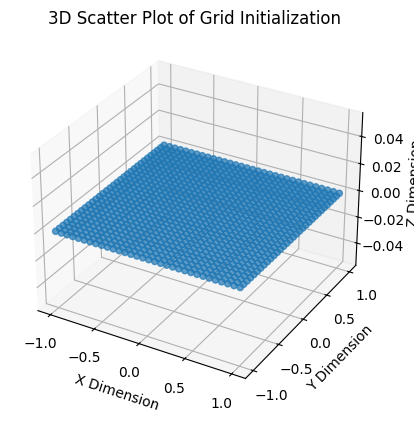

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Generate random data equivalent to torch.Size([1024, 3])
data = means

# Extract x, y, z coordinates
x = data[:, 0]
y = data[:, 1]
z = data[:, 2]

# Plot the 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, alpha=0.7)

# Label axes
ax.set_xlabel('X Dimension')
ax.set_ylabel('Y Dimension')
ax.set_zlabel('Z Dimension')
ax.set_title('3D Scatter Plot of Grid Initialization')

plt.show()


In [6]:
# No grid / standard initialization

bd = 2
means_1 = bd * (torch.rand(num_points, 3) - 0.5)

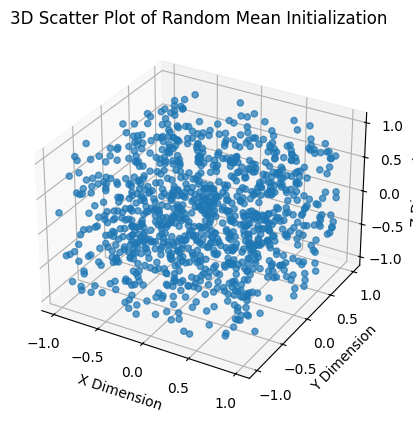

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Generate random data equivalent to torch.Size([1024, 3])
data_1 = means_1

# Extract x, y, z coordinates
x = data_1[:, 0]
y = data_1[:, 1]
z = data_1[:, 2]

# Plot the 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, alpha=0.7)

# Label axes
ax.set_xlabel('X Dimension')
ax.set_ylabel('Y Dimension')
ax.set_zlabel('Z Dimension')
ax.set_title('3D Scatter Plot of Random Mean Initialization')

plt.show()


# Gaussian Splatting 

In [8]:
class SimpleTrainer:
    """Trains random gaussians to fit an image."""

    def __init__(
        self,
        gt_image: Tensor,
        num_points: int = 2000,
        use_grid: bool = False
    ):
        self.device = torch.device("cuda:0")
        self.gt_image = gt_image.to(device=self.device)
        self.num_points = num_points

        fov_x = math.pi / 2.0
        self.H, self.W = gt_image.shape[0], gt_image.shape[1]
        self.focal = 0.5 * float(self.W) / math.tan(0.5 * fov_x)
        self.img_size = torch.tensor([self.W, self.H, 1], device=self.device)
        self.use_grid = use_grid
        
        self._init_gaussians()

    def _init_means(self):
        if self.use_grid:
            square_root = round(math.sqrt(self.num_points))
            if square_root ** 2 != self.num_points:
                raise ValueError(
                    f"When init_grid is True and grid_dimensionality is '2D', "
                    f"num_points must be a perfect square. Received num_points={self.num_points}."
                )
            grid_size = square_root
            bd_min, bd_max = (-1.0, 1.0)
            
            # 2D Grid Initialization (z = 0)
            grid_x = torch.linspace(bd_min, bd_max, grid_size, device=self.device)
            grid_y = torch.linspace(bd_min, bd_max, grid_size, device=self.device)
            
            mesh = torch.meshgrid(grid_x, grid_y, indexing='ij')
            grid_points_2d = torch.stack(mesh, dim=-1).reshape(-1, 2)
            
            # Append a fixed z-coordinate (e.g., z = 0)
            fixed_z = torch.zeros((self.num_points, 1), device=self.device)
            self.means = torch.cat([grid_points_2d, fixed_z], dim=1)
        else:
            bd = 2
            self.means = bd * (torch.rand(self.num_points, 3, device=self.device) - 0.5)
            
    def _init_gaussians(self):
        """Random gaussians"""

        # Initi means (center location)
        self._init_means()
        
        # Init scales (spread)
        self.scales = torch.rand(self.num_points, 3, device=self.device)
        
        # Init colors
        d = 3
        self.rgbs = torch.rand(self.num_points, d, device=self.device)

        # Init quaternions (rotation)
        u = torch.rand(self.num_points, 1, device=self.device)
        v = torch.rand(self.num_points, 1, device=self.device)
        w = torch.rand(self.num_points, 1, device=self.device)

        self.quats = torch.cat(
            [
                torch.sqrt(1.0 - u) * torch.sin(2.0 * math.pi * v),
                torch.sqrt(1.0 - u) * torch.cos(2.0 * math.pi * v),
                torch.sqrt(u) * torch.sin(2.0 * math.pi * w),
                torch.sqrt(u) * torch.cos(2.0 * math.pi * w),
            ],
            -1,
        )

        # Initi opacities
        self.opacities = torch.ones((self.num_points), device=self.device)

        # Initi camera view
        self.viewmat = torch.tensor(
            [
                [1.0, 0.0, 0.0, 0.0],
                [0.0, 1.0, 0.0, 0.0],
                [0.0, 0.0, 1.0, 8.0],
                [0.0, 0.0, 0.0, 1.0],
            ],
            device=self.device,
        )

        # Init background
        self.background = torch.zeros(d, device=self.device)


        self.means.requires_grad = True
        # If a grid is used, don't learn the position of the Gaussians, keep the grid constant
        if self.use_grid:
            self.means.requires_grad = False
        
        self.scales.requires_grad = True
        self.quats.requires_grad = True
        self.rgbs.requires_grad = True
        self.opacities.requires_grad = True
        self.viewmat.requires_grad = False

    def train(
        self,
        iterations: int = 1000,
        lr: float = 0.01,
        save_imgs: bool = False,
        save_name: str = "",
        model_type: Literal["3dgs", "2dgs"] = "3dgs",
    ):
        optimizer = optim.Adam(
            [self.rgbs, self.means, self.scales, self.opacities, self.quats], lr
        )
        mse_loss = torch.nn.MSELoss()
        frames = []
        times = [0] * 2  # rasterization, backward
        K = torch.tensor(
            [
                [self.focal, 0, self.W / 2],
                [0, self.focal, self.H / 2],
                [0, 0, 1],
            ],
            device=self.device,
        )

        if model_type == "3dgs":
            rasterize_fnc = rasterization
        elif model_type == "2dgs":
            rasterize_fnc = rasterization_2dgs

        for iter in range(iterations):
            start = time.time()

            renders = rasterize_fnc(
                self.means,
                self.quats / self.quats.norm(dim=-1, keepdim=True),
                self.scales,
                torch.sigmoid(self.opacities),
                torch.sigmoid(self.rgbs),
                self.viewmat[None],
                K[None],
                self.W,
                self.H,
                packed=False,
            )[0]
            out_img = renders[0]
            torch.cuda.synchronize()
            times[0] += time.time() - start
            loss = mse_loss(out_img, self.gt_image)
            optimizer.zero_grad()
            start = time.time()
            loss.backward()
            torch.cuda.synchronize()
            times[1] += time.time() - start
            optimizer.step()
            print(f"Iteration {iter + 1}/{iterations}, Loss: {loss.item()}")

            if save_imgs and iter % 5 == 0:
                frames.append((out_img.detach().cpu().numpy() * 255).astype(np.uint8))
        if save_imgs:
            # save them as a gif with PIL
            frames = [Image.fromarray(frame) for frame in frames]
            out_dir = os.path.join(os.getcwd(), "results")
            os.makedirs(out_dir, exist_ok=True)
            frames[0].save(
                f"{out_dir}/training{save_name}.gif",
                save_all=True,
                append_images=frames[1:],
                optimize=False,
                duration=5,
                loop=0,
            )
        print(f"Total(s):\nRasterization: {times[0]:.3f}, Backward: {times[1]:.3f}")
        print(
            f"Per step(s):\nRasterization: {times[0]/iterations:.5f}, Backward: {times[1]/iterations:.5f}"
        )

In [9]:
def image_path_to_tensor(image_path: Path):
    import torchvision.transforms as transforms

    img = Image.open(image_path)
    transform = transforms.ToTensor()
    img_tensor = transform(img).permute(1, 2, 0)[..., :3]
    return img_tensor

In [10]:
def image_to_tensor(img):
    import torchvision.transforms as transforms

    transform = transforms.ToTensor()
    img_tensor = transform(img).permute(1, 2, 0)[..., :3]
    return img_tensor

In [11]:
def train_splat(
    height: int = 32,
    width: int = 32,
    num_points: int = 1000,
    save_imgs: bool = True,
    save_name: str = "",
    img_path: Optional[Path] = None,
    img: Optional = None,
    iterations: int = 1000,
    lr: float = 0.01,
    model_type: Literal["3dgs", "2dgs"] = "3dgs",
    use_grid: bool = False
) -> None:
    if img_path:
        gt_image = image_path_to_tensor(img_path)
    elif img:
        gt_image = image_to_tensor(img)
    else:
        gt_image = torch.ones((height, width, 3)) * 1.0
        # make top left and bottom right red, blue
        gt_image[: height // 2, : width // 2, :] = torch.tensor([1.0, 0.0, 0.0])
        gt_image[height // 2 :, width // 2 :, :] = torch.tensor([0.0, 0.0, 1.0])

    trainer = SimpleTrainer(gt_image=gt_image, num_points=num_points, use_grid=use_grid)
    trainer.train(
        iterations=iterations,
        lr=lr,
        save_imgs=save_imgs,
        save_name=save_name,
        model_type=model_type,
    )

In [13]:
!pip install torchvision

  Using cached torchvision-0.20.1-cp310-cp310-manylinux1_x86_64.whl (7.2 MB)


In [14]:
import torchvision
import matplotlib.pyplot as plt

In [15]:
torchvision.__version__

'0.20.1+cu124'

In [16]:
cifar_data = torchvision.datasets.CIFAR10(root='datasets/cifar/', download=True)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100.0%


Extracting datasets/cifar/cifar-10-python.tar.gz to datasets/cifar/


In [17]:
cifar_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: datasets/cifar/
    Split: Train

In [18]:
cifar_data.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

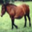

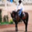

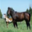

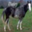

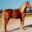

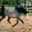

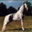

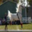

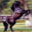

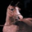

In [26]:
# Print some images with the same label (label = 7 corresponds to a horse) to get a feeling of the CIFAR Dataset.
horse_imgs = []
count = 0

for img in cifar_data:
    if img[1] == 7:
        img[0].show()
        horse_imgs.append(img[0])
        count += 1
    if count > 9:
        break

In [62]:
cifar_imgs = [Image.fromarray(img) for img in cifar_data.data]

In [28]:
cifar_labels = cifar_data.targets

In [29]:
cifar_5_imgs = cifar_imgs[:5]

In [30]:
for i, img in enumerate(horse_imgs):
    train_splat(img=img, save_name=f"_idx{i}_no_grid_1024p", save_imgs=True, num_points=32*32)

Iteration 1/1000, Loss: 0.2626510560512543
Iteration 2/1000, Loss: 0.26066482067108154
Iteration 3/1000, Loss: 0.2587233781814575
Iteration 4/1000, Loss: 0.2570071220397949
Iteration 5/1000, Loss: 0.2552669942378998
Iteration 6/1000, Loss: 0.25343769788742065
Iteration 7/1000, Loss: 0.2516515254974365
Iteration 8/1000, Loss: 0.24984735250473022
Iteration 9/1000, Loss: 0.24803051352500916
Iteration 10/1000, Loss: 0.24615871906280518
Iteration 11/1000, Loss: 0.24422988295555115
Iteration 12/1000, Loss: 0.2423090934753418
Iteration 13/1000, Loss: 0.24039572477340698
Iteration 14/1000, Loss: 0.23840558528900146
Iteration 15/1000, Loss: 0.23648974299430847
Iteration 16/1000, Loss: 0.23451738059520721
Iteration 17/1000, Loss: 0.23252689838409424
Iteration 18/1000, Loss: 0.2304888814687729
Iteration 19/1000, Loss: 0.22844402492046356
Iteration 20/1000, Loss: 0.22629258036613464
Iteration 21/1000, Loss: 0.22425150871276855
Iteration 22/1000, Loss: 0.22211715579032898
Iteration 23/1000, Loss: 0

In [31]:
for i, img in enumerate(horse_imgs):
    train_splat(img=img, save_name=f"_idx{i}_with_grid_1024p", save_imgs=True, num_points=32*32, use_grid=True)

Iteration 1/1000, Loss: 0.2655773162841797
Iteration 2/1000, Loss: 0.26442861557006836
Iteration 3/1000, Loss: 0.26324233412742615
Iteration 4/1000, Loss: 0.26207634806632996
Iteration 5/1000, Loss: 0.2608853578567505
Iteration 6/1000, Loss: 0.2596569359302521
Iteration 7/1000, Loss: 0.2584981918334961
Iteration 8/1000, Loss: 0.2573034465312958
Iteration 9/1000, Loss: 0.2561553418636322
Iteration 10/1000, Loss: 0.25490906834602356
Iteration 11/1000, Loss: 0.25372347235679626
Iteration 12/1000, Loss: 0.25251445174217224
Iteration 13/1000, Loss: 0.25131648778915405
Iteration 14/1000, Loss: 0.25013458728790283
Iteration 15/1000, Loss: 0.2489028424024582
Iteration 16/1000, Loss: 0.24768374860286713
Iteration 17/1000, Loss: 0.24643473327159882
Iteration 18/1000, Loss: 0.24519050121307373
Iteration 19/1000, Loss: 0.2439802587032318
Iteration 20/1000, Loss: 0.2427596151828766
Iteration 21/1000, Loss: 0.2414940893650055
Iteration 22/1000, Loss: 0.2402418851852417
Iteration 23/1000, Loss: 0.239

In [32]:
# for i, img in enumerate(horse_imgs):
#     train_splat(img=img, save_name=f"_idx{i}_with_grid_1024p_2dgs", save_imgs=True, num_points=32*32, use_grid=True, model_type="2dgs")

Iteration 1/1000, Loss: 0.2702288031578064
Iteration 2/1000, Loss: 0.26887771487236023
Iteration 3/1000, Loss: 0.2675971984863281
Iteration 4/1000, Loss: 0.2662545442581177
Iteration 5/1000, Loss: 0.2649584710597992
Iteration 6/1000, Loss: 0.2636984586715698
Iteration 7/1000, Loss: 0.26242488622665405
Iteration 8/1000, Loss: 0.26117759943008423
Iteration 9/1000, Loss: 0.259906142950058
Iteration 10/1000, Loss: 0.2585684657096863
Iteration 11/1000, Loss: 0.25727251172065735
Iteration 12/1000, Loss: 0.25593239068984985
Iteration 13/1000, Loss: 0.2546117603778839
Iteration 14/1000, Loss: 0.2532851994037628
Iteration 15/1000, Loss: 0.2518879771232605
Iteration 16/1000, Loss: 0.2504767179489136
Iteration 17/1000, Loss: 0.2490372657775879
Iteration 18/1000, Loss: 0.24751411378383636
Iteration 19/1000, Loss: 0.2459508180618286
Iteration 20/1000, Loss: 0.2443213164806366
Iteration 21/1000, Loss: 0.2427501529455185
Iteration 22/1000, Loss: 0.2410958707332611
Iteration 23/1000, Loss: 0.239352926

In [33]:
for i, img in enumerate(horse_imgs):
    train_splat(img=img, save_name=f"_idx{i}_with_grid_256p", save_imgs=True, num_points=16*16, use_grid=True)

Iteration 1/1000, Loss: 0.26979848742485046
Iteration 2/1000, Loss: 0.26894134283065796
Iteration 3/1000, Loss: 0.2681051194667816
Iteration 4/1000, Loss: 0.2672571837902069
Iteration 5/1000, Loss: 0.266422837972641
Iteration 6/1000, Loss: 0.26557236909866333
Iteration 7/1000, Loss: 0.26472926139831543
Iteration 8/1000, Loss: 0.2639133632183075
Iteration 9/1000, Loss: 0.26307106018066406
Iteration 10/1000, Loss: 0.2622178792953491
Iteration 11/1000, Loss: 0.26135969161987305
Iteration 12/1000, Loss: 0.2604885399341583
Iteration 13/1000, Loss: 0.25964805483818054
Iteration 14/1000, Loss: 0.258789598941803
Iteration 15/1000, Loss: 0.2578884959220886
Iteration 16/1000, Loss: 0.25699591636657715
Iteration 17/1000, Loss: 0.25608885288238525
Iteration 18/1000, Loss: 0.2552024722099304
Iteration 19/1000, Loss: 0.25432127714157104
Iteration 20/1000, Loss: 0.2533292770385742
Iteration 21/1000, Loss: 0.25236785411834717
Iteration 22/1000, Loss: 0.25138020515441895
Iteration 23/1000, Loss: 0.2503

In [34]:
for i, img in enumerate(horse_imgs):
    train_splat(img=img, save_name=f"_idx{i}_with_grid_4096p", save_imgs=True, num_points=64*64, use_grid=True)

Iteration 1/1000, Loss: 0.2598242461681366
Iteration 2/1000, Loss: 0.2584090232849121
Iteration 3/1000, Loss: 0.25700682401657104
Iteration 4/1000, Loss: 0.255593478679657
Iteration 5/1000, Loss: 0.25420448184013367
Iteration 6/1000, Loss: 0.25282296538352966
Iteration 7/1000, Loss: 0.25144875049591064
Iteration 8/1000, Loss: 0.2500447630882263
Iteration 9/1000, Loss: 0.2487008273601532
Iteration 10/1000, Loss: 0.2472982406616211
Iteration 11/1000, Loss: 0.2458934485912323
Iteration 12/1000, Loss: 0.24455034732818604
Iteration 13/1000, Loss: 0.24321238696575165
Iteration 14/1000, Loss: 0.2418729066848755
Iteration 15/1000, Loss: 0.2405843436717987
Iteration 16/1000, Loss: 0.23928646743297577
Iteration 17/1000, Loss: 0.23802463710308075
Iteration 18/1000, Loss: 0.23671716451644897
Iteration 19/1000, Loss: 0.23541522026062012
Iteration 20/1000, Loss: 0.23414376378059387
Iteration 21/1000, Loss: 0.23288540542125702
Iteration 22/1000, Loss: 0.2316036820411682
Iteration 23/1000, Loss: 0.230

In [34]:
for i, img in enumerate(horse_imgs):
    train_splat(img=img, save_name=f"_idx{i}_with_grid_4096p", save_imgs=True, num_points=64*64, use_grid=True)

Iteration 1/1000, Loss: 0.2598242461681366
Iteration 2/1000, Loss: 0.2584090232849121
Iteration 3/1000, Loss: 0.25700682401657104
Iteration 4/1000, Loss: 0.255593478679657
Iteration 5/1000, Loss: 0.25420448184013367
Iteration 6/1000, Loss: 0.25282296538352966
Iteration 7/1000, Loss: 0.25144875049591064
Iteration 8/1000, Loss: 0.2500447630882263
Iteration 9/1000, Loss: 0.2487008273601532
Iteration 10/1000, Loss: 0.2472982406616211
Iteration 11/1000, Loss: 0.2458934485912323
Iteration 12/1000, Loss: 0.24455034732818604
Iteration 13/1000, Loss: 0.24321238696575165
Iteration 14/1000, Loss: 0.2418729066848755
Iteration 15/1000, Loss: 0.2405843436717987
Iteration 16/1000, Loss: 0.23928646743297577
Iteration 17/1000, Loss: 0.23802463710308075
Iteration 18/1000, Loss: 0.23671716451644897
Iteration 19/1000, Loss: 0.23541522026062012
Iteration 20/1000, Loss: 0.23414376378059387
Iteration 21/1000, Loss: 0.23288540542125702
Iteration 22/1000, Loss: 0.2316036820411682
Iteration 23/1000, Loss: 0.230

In [35]:
for i, img in enumerate(horse_imgs):
    train_splat(img=img, save_name=f"_idx{i}_with_grid_4096p_2dgs", save_imgs=True, num_points=64*64, use_grid=True, model_type="2dgs")

Iteration 1/1000, Loss: 0.2625541090965271
Iteration 2/1000, Loss: 0.2606632113456726
Iteration 3/1000, Loss: 0.2588832378387451
Iteration 4/1000, Loss: 0.2570968270301819
Iteration 5/1000, Loss: 0.25531572103500366
Iteration 6/1000, Loss: 0.25350695848464966
Iteration 7/1000, Loss: 0.2517740726470947
Iteration 8/1000, Loss: 0.24997252225875854
Iteration 9/1000, Loss: 0.24819505214691162
Iteration 10/1000, Loss: 0.24638211727142334
Iteration 11/1000, Loss: 0.24459485709667206
Iteration 12/1000, Loss: 0.24278990924358368
Iteration 13/1000, Loss: 0.24092018604278564
Iteration 14/1000, Loss: 0.23912934958934784
Iteration 15/1000, Loss: 0.23732398450374603
Iteration 16/1000, Loss: 0.2354455441236496
Iteration 17/1000, Loss: 0.23354265093803406
Iteration 18/1000, Loss: 0.23160430788993835
Iteration 19/1000, Loss: 0.22963139414787292
Iteration 20/1000, Loss: 0.22768887877464294
Iteration 21/1000, Loss: 0.22576472163200378
Iteration 22/1000, Loss: 0.22380027174949646
Iteration 23/1000, Loss: 

In [2]:
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [36]:
for i, img in enumerate(horse_imgs):
    train_splat(img=img, save_name=f"_idx{i}_with_grid_256p_2dgs", save_imgs=True, num_points=16*16, use_grid=True, model_type="2dgs")

Iteration 1/1000, Loss: 0.27388203144073486
Iteration 2/1000, Loss: 0.2730194330215454
Iteration 3/1000, Loss: 0.2721606492996216
Iteration 4/1000, Loss: 0.2713492512702942
Iteration 5/1000, Loss: 0.270537793636322
Iteration 6/1000, Loss: 0.2696991562843323
Iteration 7/1000, Loss: 0.2688646912574768
Iteration 8/1000, Loss: 0.2680893838405609
Iteration 9/1000, Loss: 0.2673088014125824
Iteration 10/1000, Loss: 0.26650163531303406
Iteration 11/1000, Loss: 0.26570388674736023
Iteration 12/1000, Loss: 0.2649151682853699
Iteration 13/1000, Loss: 0.26410138607025146
Iteration 14/1000, Loss: 0.26328760385513306
Iteration 15/1000, Loss: 0.26241570711135864
Iteration 16/1000, Loss: 0.26155373454093933
Iteration 17/1000, Loss: 0.26067283749580383
Iteration 18/1000, Loss: 0.25976863503456116
Iteration 19/1000, Loss: 0.25882408022880554
Iteration 20/1000, Loss: 0.2578239142894745
Iteration 21/1000, Loss: 0.2568155527114868
Iteration 22/1000, Loss: 0.25573965907096863
Iteration 23/1000, Loss: 0.2546

In [74]:
import os
from IPython.display import display, HTML, Image

def visualize_gifs(directory, substrings):
    """
    Visualize all GIF files in the specified directory whose filenames contain any of the specified substrings.

    Parameters:
        directory (str): Path to the directory containing GIF files.
        substrings (list of str): List of substrings to filter GIF filenames.
    """
    if not os.path.isdir(directory):
        raise ValueError(f"The specified directory '{directory}' does not exist or is not a directory.")

    # Filter GIF files based on substrings
    matching_gifs = [
        f for f in os.listdir(directory)
        if f.endswith('.gif') and any(substring in f for substring in substrings)
    ]

    if not matching_gifs:
        print("No GIFs found matching the specified substrings.")
        return

    # Display GIFs
    for gif in matching_gifs:
        gif_path = os.path.join(directory, gif)
        display(HTML(f"""
            <div style='margin-bottom: 20px;'>
                <h4>{gif}</h4>
                <img src='{gif_path}' style='max-width: 100%; height: auto;'>
            </div>
        """))

# Example usage in Jupyter Notebook:
# visualize_gifs("path/to/directory", ["substring1", "substring2"])


In [75]:
import os
from IPython.display import display, HTML

def visualize_gifs(directory, substrings):
    """
    Visualize all GIF files in the specified directory whose filenames contain any of the specified substrings.

    Parameters:
        directory (str): Path to the directory containing GIF files.
        substrings (list of str): List of substrings to filter GIF filenames.
    """
    if not os.path.isdir(directory):
        raise ValueError(f"The specified directory '{directory}' does not exist or is not a directory.")

    # Filter GIF files based on substrings
    matching_gifs = [
        f for f in os.listdir(directory)
        if f.endswith('.gif') and any(substring in f for substring in substrings)
    ]

    if not matching_gifs:
        print("No GIFs found matching the specified substrings.")
        return

    # Create HTML to display GIFs side by side
    gif_html = "<div style='display: flex; flex-wrap: wrap; gap: 10px;'>"
    for gif in matching_gifs:
        gif_path = os.path.join(directory, gif)
        gif_html += f"<div><img src='{gif_path}' style='max-width: 200px; height: auto;'></div>"
    gif_html += "</div>"

    # Create HTML for the list of filenames
    filenames_html = "<ol>"
    for gif in matching_gifs:
        filenames_html += f"<li>{gif}</li>"
    filenames_html += "</ol>"

    # Display the GIFs and filenames
    display(HTML(gif_html + filenames_html))

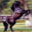

In [76]:
horse_imgs[8]

In [55]:
visualize_gifs("./results", ["idx8"])

In [77]:
from itertools import product

def generate_save_name(params):
    """
    Generate a dynamic save_name based on the parameters.

    Args:
        params (dict): Dictionary of parameters.

    Returns:
        str: Generated save_name.
    """
    components = [
        "with_grid" if params["use_grid"] else "no_grid",
        f"{params['num_points']}",
        f"{params['model_type']}" if "model_type" in params else "3dgs"
    ]
    return "_".join(components)

def generate_configs(param_grid):
    """
    Generate all parameter combinations from the parameter grid.

    Args:
        param_grid (dict): Dictionary where keys are parameter names and values are lists of possible values.

    Returns:
        list: List of dictionaries representing all combinations of parameters.
    """
    keys, values = zip(*param_grid.items())
    combinations = [dict(zip(keys, combo)) for combo in product(*values)]
    return combinations

def run_experiments(images, param_grid):
    """
    Run train_splat for each image and every combination of parameters.

    Args:
        images (list): List of input images.
        param_grid (dict): Dictionary of parameter grids.
    """
    configs = generate_configs(param_grid)
    
    for i, img in enumerate(images):
        for config in configs:
            # Generate a save_name dynamically
            config["save_name"] = f"_img{i}_" + generate_save_name(config)
            print(config["save_name"])
            train_splat(img=img, **config)

In [78]:
# Define the parameter grid
param_grid = {
    "num_points": [8 * 8, 16 * 16, 32 * 32, 64 * 64],
    "use_grid": [True, False],
    "model_type": ["3dgs", "2dgs"],
    "save_imgs": [True],  # Fixed parameter, only one value
}

In [82]:
# Run experiments
run_experiments(horse_imgs[6:8], param_grid)

_img0_with_grid_64_3dgs
Iteration 1/1000, Loss: 0.13900232315063477
Iteration 2/1000, Loss: 0.13853606581687927
Iteration 3/1000, Loss: 0.1380944550037384
Iteration 4/1000, Loss: 0.13766634464263916
Iteration 5/1000, Loss: 0.13723570108413696
Iteration 6/1000, Loss: 0.13681602478027344
Iteration 7/1000, Loss: 0.1364293098449707
Iteration 8/1000, Loss: 0.13603049516677856
Iteration 9/1000, Loss: 0.1356445550918579
Iteration 10/1000, Loss: 0.13527056574821472
Iteration 11/1000, Loss: 0.13491474092006683
Iteration 12/1000, Loss: 0.1345493048429489
Iteration 13/1000, Loss: 0.1341698169708252
Iteration 14/1000, Loss: 0.13381563127040863
Iteration 15/1000, Loss: 0.13345520198345184
Iteration 16/1000, Loss: 0.13312381505966187
Iteration 17/1000, Loss: 0.132786363363266
Iteration 18/1000, Loss: 0.13244187831878662
Iteration 19/1000, Loss: 0.13211998343467712
Iteration 20/1000, Loss: 0.13180533051490784
Iteration 21/1000, Loss: 0.13148921728134155
Iteration 22/1000, Loss: 0.13119544088840485
It

In [84]:
visualize_gifs("./results", ["img0"])

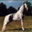

In [86]:
horse_imgs[6]